In [1]:
%matplotlib inline

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from cv2 import VideoWriter, VideoWriter_fourcc
import pandas as pd
#import torch
from scipy import signal, ndimage, spatial
from scipy.signal import correlate
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
import math 
#from signal_alignment import phase_align, chisqr_align
from scipy.interpolate import interp1d
import scipy.stats as stats
from scipy.stats import spearmanr
from plot_kinematics_basic import plot_kinematics 

import get_onsets_basic

### Function Definitions 

In [3]:
# cleaning video data 

def cleaning_video_df(DF):
    
    # choose the needed columns and convert the values to mm
    DF = DF[["BAG_Frame_number",'Time_Stamp (s)','Video_Frame_number',
             'landmark_48', 'landmark_48.1', 'landmark_48.2', 'landmark_54',
            'landmark_54.1', 'landmark_54.2', 'landmark_51', 'landmark_51.1',
            'landmark_51.2', 'landmark_57', 'landmark_57.1', 'landmark_57.2']]
  
    
    DF = DF.rename(columns={'Time_Stamp (s)': 'Time', "landmark_48": "X_LR", "landmark_48.1": "Y_LR",
                           "landmark_48.2": "Z_LR", "landmark_54": "X_LLeft",
                           "landmark_54.1": "Y_LLeft", "landmark_54.2": "Z_LLeft",
                           "landmark_51": "X_UL", "landmark_51.1": "Y_UL",
                           "landmark_51.2": "Z_UL", "landmark_57": "X_LL", "landmark_57.1": "Y_LL",
                           "landmark_57.2": "Z_LL"})
    
    DF = DF.astype({ "X_LR": np.double, "Y_LR": np.double,"Z_LR": np.double, "X_LLeft": np.double,
                            "Y_LLeft": np.double, "Z_LLeft": np.double, "X_UL": np.double,  "Y_UL": np.double,
                            "Z_UL": np.double,  "X_LL": np.double,  "Y_LL": np.double, "Z_LL": np.double})
    
    # conver the values from m to mm
    DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]] =  DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]]*1000
    return DF


# Reading the video files needed 
task video file
Rest video file for normalization 

In [34]:
input_csv_features = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/results/TEST/orofacial_signals_metric_output_BBP_NORMAL.csv"

input_csv_landmarks = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/video_data/ALS/old/A001/landmarks_finetuned_w15/A001_02_BBP_NORMAL_landmarksFiltered.csv"

df_f = pd.read_csv(input_csv_features)
df_l = pd.read_csv(input_csv_landmarks)
df_f.head()

,Unnamed: 0,subject_id,rep,task,type,Time_Stamp,O,vO,aO,jO,...,jLC_2,A_MOUTH,rA_MOUTH,lA_MOUTH,A_Mouth_diff,A_JAW,rA_JAW,lA_JAW,A_JAW_diff,e
0,0,A001,0,BBP_NORMAL,1,0.515563,1.067899,-0.011932,0.023863,-1.110223e-16,...,-5.551115e-17,2.016352,1.031595,0.984756,0.046839,1.155914,0.909766,0.246148,0.663619,0.976644
1,1,A001,0,BBP_NORMAL,1,0.536186,1.067899,0.011932,0.023863,-1.110223e-16,...,-5.551115e-17,2.064395,1.031595,1.032800,0.001205,1.267759,0.909766,0.357993,0.551773,0.977381
2,2,A001,0,BBP_NORMAL,1,0.556809,1.091762,0.035795,0.023863,-1.110223e-16,...,-5.551115e-17,2.107523,1.054475,1.053049,0.001426,1.233667,0.917681,0.315986,0.601696,0.976348
3,3,A001,0,BBP_NORMAL,1,0.577431,1.136151,0.054651,0.016353,-1.126458e-02,...,-9.992584e-02,2.226521,1.114171,1.112350,0.001821,1.558590,1.045005,0.513585,0.531421,0.974348
4,4,A001,0,BBP_NORMAL,1,0.598054,1.848852,1.046857,1.478881,2.197546e+00,...,1.824895e-01,3.604086,1.770727,1.833359,0.062633,2.069403,1.249011,0.820392,0.428620,0.928109


In [69]:
print(df_f.shape)

features = df_f.columns

(878, 51)


In [27]:
df_l_x_col = []
df_l_y_col = []

for col in df_l.columns:
    if col == 'Time_Stamp (s)':
        df_l_x_col.append(col)
        df_l_y_col.append(col)
    if "landmark_" in col and "x" in col:
        df_l_x_col.append(col)
    elif "landmark_" in col and "y" in col:
        df_l_y_col.append(col)
    
    
df_l_x = df_l[df_l_x_col]
df_l_y = df_l[df_l_y_col]
print(df_l_x.shape)
print(df_l_y.shape)

df_l_x = df_l_x.loc[df_l_x['Time_Stamp (s)'].isin(df_f.Time_Stamp.values)]
print(df_l_x.shape)

df_l_y = df_l_y.loc[df_l_y['Time_Stamp (s)'].isin(df_f.Time_Stamp.values)]
print(df_l_y.shape)

print(len(df_f.Time_Stamp.values))

(1335, 69)
(1335, 69)
(875, 69)
(875, 69)
878


In [33]:
# here is weird thing going on
# we don't see 

#np.in1d(df_f.Time_Stamp.values,df_l_y['Time_Stamp (s)'].values)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [62]:
# get the data per rep in order to then plot them 
feature = 'O'

rep_f = df_f.loc[df_f['rep']==1]

rep_y = df_l_y.loc[df_l_y['Time_Stamp (s)'].isin(rep_f.Time_Stamp.values)]

rep_x = df_l_x.loc[df_l_x['Time_Stamp (s)'].isin(rep_f.Time_Stamp.values)]
time = rep_f['Time_Stamp'].values
rep_y= rep_y.drop('Time_Stamp (s)', axis =1)
rep_x= rep_x.drop('Time_Stamp (s)', axis =1)

rep_x = rep_x.transpose()

rep_y = rep_y.transpose()

speed = rep_f['O'].values
print(rep_f.shape)
print(rep_x.transpose().shape)
print(rep_y.shape)
print(len(speed))
print(len(time))

(82, 51)
(81, 68)
(68, 81)
82
82


In [59]:
speed

array([1.05807395, 1.1524939 , 2.02812519, 2.18333408, 2.54330865,
       2.65688498, 2.81747824, 2.81450451, 2.81051933, 2.8104732 ,
       2.72286817, 2.7179265 , 2.63051845, 2.52970635, 2.19416667,
       2.18139178, 2.09576974, 2.00826434, 1.67624732, 1.14365184,
       1.05749855, 1.07029432, 1.04910242, 1.0705944 , 1.05693934,
       2.19840031, 2.5394663 , 2.88709128, 2.88709128, 2.8896319 ,
       2.8896319 , 2.45548596, 1.94118789, 1.50829631, 1.23151006,
       1.23162563, 1.24027377, 1.84958479, 2.19696933, 2.19696933,
       2.2076759 , 2.11513599, 2.02731948, 2.02731948, 2.10205347,
       2.19857991, 2.21119822, 2.28590417, 2.29718469, 2.46032495,
       2.54775345, 2.54775345, 2.54775345, 2.45978992, 2.02273818,
       1.67456661, 1.33825472, 1.25476724, 1.22632113, 1.22632113,
       1.22632113, 1.46364311, 1.92287301, 2.19669369, 2.19669369,
       2.1858001 , 1.74770376, 1.33722299, 1.32559725, 1.32559725,
       1.32634881, 1.94303611, 2.11808356, 2.11808356, 2.11808

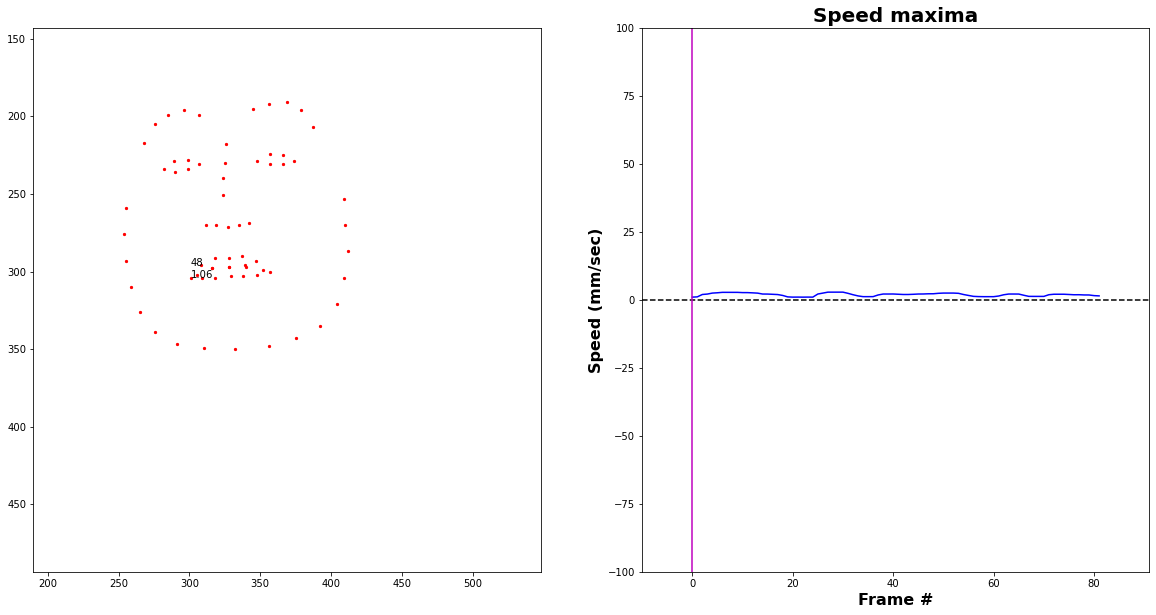

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

ET: 6.62253999710083


In [67]:
plot_kinematics(rep_x.values, rep_y.values,48 , speed, True)

In [70]:
print(features)

Index(['Unnamed: 0', 'subject_id', 'rep', 'task', 'type', 'Time_Stamp', 'O',
       'vO', 'aO', 'jO', 'W', 'vW', 'aW', 'jW', 'LL', 'vLL', 'aLL', 'jLL',
       'RC', 'vRC', 'aRC', 'jRC', 'LC', 'vLC', 'aLC', 'jLC', 'RJ', 'vRJ',
       'aRJ', 'jRJ', 'LJ', 'vLJ', 'aLJ', 'jLJ', 'RC_2', 'vRC_2', 'aRC_2',
       'jRC_2', 'LC_2', 'vLC_2', 'aLC_2', 'jLC_2', 'A_MOUTH', 'rA_MOUTH',
       'lA_MOUTH', 'A_Mouth_diff', 'A_JAW', 'rA_JAW', 'lA_JAW', 'A_JAW_diff',
       'e'],
      dtype='object')


In [78]:
df_f['rep'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

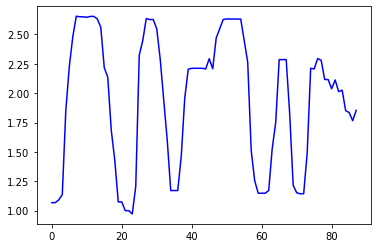

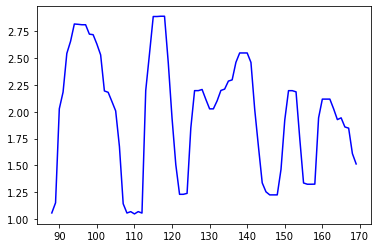

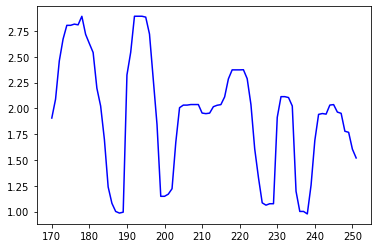

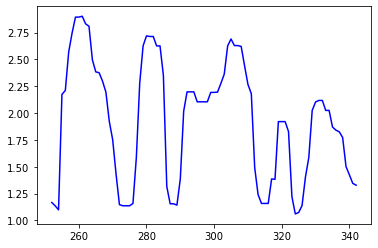

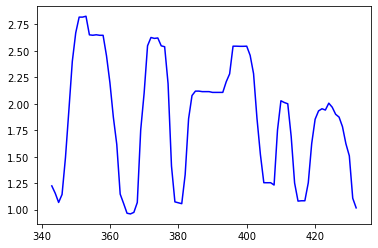

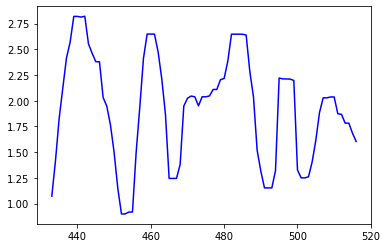

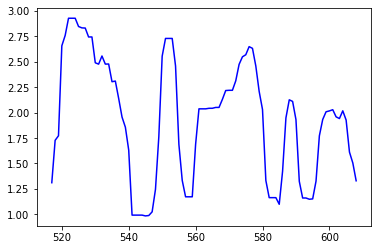

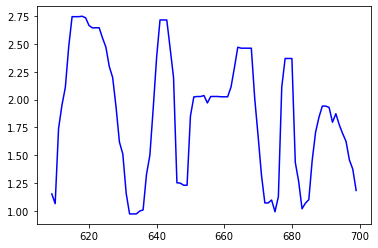

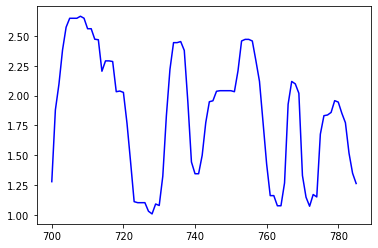

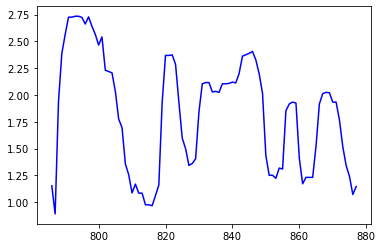

In [89]:
# Plot the reps of a specific feature

feature = 'O'

for rep in df_f['rep'].unique():
    rep_f = df_f.loc[df_f['rep']==rep]
    plt.figure()
    plt.plot(rep_f[feature],'b')
    
    if 0: 
        plt.figure()
        plt.plot(rep_f['vO'],'r')
        plt.plot(rep_f['aO'],'g')


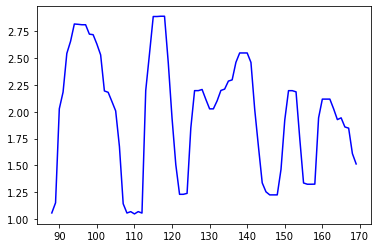

In [81]:
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name

input_video_file = 
cap = cv2.VideoCapture('chaplin.mp4')

# Check if camera opened successfully

if (cap.isOpened()== False):  
    print("Error opening video stream or file")

 

# Read until video is completed

while(cap.isOpened()):

  # Capture frame-by-frame

    ret, frame = cap.read()
    
    if ret == True:

    # Display the resulting frame

    cv2.imshow('Frame',frame)

    # Press Q on keyboard to  exit

    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

  # Break the loop
    else: 
        break

# When everything done, release the video capture object

cap.release()

# Closes all the frames

cv2.destroyAllWindows()


# Plot some raw data 

## Defining the fuctions to be tested for feature engineering 

In [ ]:
def area_of_triangle(A,B,C):

    """
    computes the area of a triangle given by 3 points in 2d or 3d

    A, B and C must be numpy arrays

    it works with vectors A=[a1,a2,a3], B=[b1,b2,b3], c=[c1,c2,c3] or matrices

    A=[[a11,a12,a13],...[a1n,a2n,b3n]], B=[[b11,b12,b13],...[b1n,b2n,b3n]], C=[[c11,c12,c13],...[c1n,c2n,c3n]]

    """

    As = A.shape
    Bs = B.shape
    Cs = C.shape
   
    if len(As) == 1 :

        #we got vectors

        if (As[0]>3) or (Bs[0]>3) or (Cs[0]>3):

            raise Exception('coordinates can only be 2d or 3d')

            return None

    else:

        #check at least one of the dimensions is two or three
        if (As[0]==2) or (As[0]==3) or (As[1]==2) or (As[1]==3):

            #one of the dimensions of A is 2 or 3, now check that all the vectors have the same size
            if (As!=Bs) or (As!=Cs):

                raise Exception('vectors must be the same size')
                return None

            else:
                #move forward
                pass

        else:

            raise Exception('coordinates can only be 2d or 3d')

            return None

    #at this point we know that one of the dimensions has 2 or 3 elements we move forward assuming that
    #the user provided the vectors with the correct size
    #move all vectors to the same origin

    AB = B-A
    AC = C-A  

    if len(As) == 1 :

        #if only one vector the simply compute the norm of the cross product
        area = (1/2)*np.linalg.norm(np.cross(AB,AC))

    else:

        #if only multiple vectors compute the norm along the axis one
        area = (1/2)*np.linalg.norm(np.cross(AB,AC), axis = 1)   

    return area

def lipDist(DF):
    
    # Assumes columns are named in a particular way 
    
    DF['Horiz_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.X_LLeft - row.X_LR)**2 + (row.Y_LLeft - row.Y_LR)**2
                                                                  + (row.Z_LLeft - row.Z_LR)**2), axis = 1) 
    DF['Vert_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.X_UL - row.X_LL)**2 + (row.Y_UL - row.Y_LL)**2 +
                                                                 (row.Z_UL - row.Z_LL)**2), axis = 1)
    return DF

In [4]:
# Signal Processing

# sampling frequency set to 100 HZ
fsample = 100

def sig_shift(signal, amount):
    length = len(signal)    
    shifted = np.zeros(length+amount - 1)
    shifted[:amount-1] = 0
    shifted[amount-1:] = signal[:]
    return shifted

def sig_norm(signal):
    signal_mean = np.mean(signal)
    signal_normalised = signal - signal_mean
    return signal_normalised

# Butterworth filter 8-order, 15hz cutoff
fc = 15
w = fc / (fsample/2)
b , a = signal.butter(8, w, btype ='lowpass')

In [33]:
def rom(list_of_arrays):

    
    reps_max_values = np.array([np.max(array) for array in list_of_arrays])
    reps_min_values = np.array([np.min(array) for array in list_of_arrays])
    
    
    ROM = reps_max_values - reps_min_values
    
    return ROM

### Reading, Cleaning, and Preprocessing DATA

In [5]:
Tasks = ['REST', 'OPEN', 'SPREAD', 'BIG_SMILE', 'PA', 'BBP', 'PUCKER', 'KISS']

TASK_DFS_VIDEO_LIST = list()

In [9]:
#####   VIDEO DATA   ######

# read the wave data files of the chosen task into dfs and store them all in a list 
path_v = r'C:\Users\jafarid\Documents\Code\ValidationStudy\video_data_processed'
ext_v=('_Landmarks3D.csv')
Files_v = os.listdir(path_v)           
Files_v = [i for i in Files_v if i.endswith(ext_v)]

for i in range(0, len(Files_v)):
    # choose which task to focus on 
    if Task in Files_v[i]:
        df = pd.read_csv(path_v+ "\\" + Files_v[i])
        df =  df.drop([0]) 
        df = cleaning_video_df(df)
        # depending on the file we are reading the indexing below needs to change 
        df['FileName'] = Files_v[i][12:-16]
        df['PatientID'] = Files_v[i][:2]
        df['DataDATE'] = Files_v[i][5:13]
        df['Task'] = Task
        for condition in Conditions:
            if condition in Files_v[i]:
                df['Condition'] = condition

            if 'Condition' not in df.columns:
                df['Condition'] = 'NORMAL'
                

        # preprocessing, using the cubic interpolation to fill in the missing data 
        df = df.interpolate(method ='cubic', limit_direction ='forward') 
        df = lipDist(df)

        left_area = area_of_triangle(df[["X_LLeft", "Y_LLeft", "Z_LLeft"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
                                       df[["X_LL", "Y_LL", "Z_LL"]].values)
        df['Area_Left'] = np.array(left_area)
        right_area = area_of_triangle(df[["X_LR", "Y_LR","Z_LR"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
                                        df[[ "X_LL", "Y_LL", "Z_LL"]].values)
        df['Area_Right'] =  np.array(right_area)        
        df["Area_Ratio"] = df.apply(lambda row: row.Area_Left/row.Area_Right, axis = 1)
        
        
        
        df['Vert_Lip_Motion_F1']= signal.filtfilt(b, a, df['Vert_Lip_Motion'])
        df['Horiz_Lip_Motion_F1'] = signal.filtfilt(b, a, df['Horiz_Lip_Motion'])
        df["Speed"] = np.gradient(df['Horiz_Lip_Motion'], df["Time"])
        
        #df['Vert_Lip_Motion_F1']= gaussian_filter(df['Vert_Lip_Motion'], sigma=3)
        #df['Horiz_Lip_Motion_F1']= gaussian_filter(df['Horiz_Lip_Motion'], sigma=3)
        #df["Speed_F1"] = gaussian_filter(np.gradient(df['Horiz_Lip_Motion_F1'], df["Time"]), 3)
        
        # Butterworth filter 8-order, 15hz cutoff
        #df['Vert_Lip_Motion_F2']= signal.filtfilt(b, a, df['Vert_Lip_Motion'])
        #df['Horiz_Lip_Motion_F2']= signal.filtfilt(b, a, df['Horiz_Lip_Motion'])
        df['Area_Right']= signal.filtfilt(b, a, df['Area_Right'])
        df['Area_Left']= signal.filtfilt(b, a, df['Area_Left'])
        #df["Speed_F2"] = signal.filtfilt(b, a, np.gradient(df['Horiz_Lip_Motion'], df["Time"]))
        
        TASK_DFS_VIDEO_LIST.append(df)
        print(Files_v[i][12:-16])

    


SPREAD_HOLD
SPREAD_NORM
SPREAD_HOLD
SPREAD_NORM
SPREAD_HOLD
SPREAD_NORM


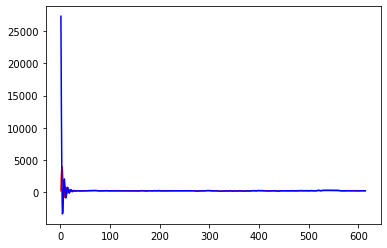

In [11]:
plt.plot(TASK_DFS_VIDEO_LIST[0]['Area_Left'],'r')
plt.plot(TASK_DFS_VIDEO_LIST[0]['Area_Right'],'b')

In [15]:
TASK_DFS_VIDEO_100HZ_LIST = list()

In [16]:
# Upsampling to 100Hz for the video data
for DF_VIDEO in TASK_DFS_VIDEO_LIST:
    WAVE_100HZ = pd.DataFrame()
    tmax = len(DF_VIDEO.Time) - 1
    tmax_value = DF_VIDEO.Time[tmax]
    tmin_value = DF_VIDEO.Time[1]
    nsample = fsample*(tmax_value - tmin_value)
    nsample = math.ceil(nsample)
    perfect_time = np.linspace(tmin_value, tmax_value, num= nsample, endpoint=True)
    WAVE_100HZ['Time'] = perfect_time
    f_motion = interp1d(DF_VIDEO.Time, DF_VIDEO['Vert_Lip_Motion_F1'], kind = 'linear')
    WAVE_100HZ['Vert_Lip_Motion'] = f_motion(perfect_time)
    f_motion2 = interp1d(DF_VIDEO.Time, DF_VIDEO['Horiz_Lip_Motion_F1'], kind = 'linear')
    WAVE_100HZ['Horiz_Lip_Motion'] = f_motion2(perfect_time)
    f_speed = interp1d(DF_VIDEO.Time, DF_VIDEO['Speed'], kind = 'linear')
    WAVE_100HZ['Speed'] = f_speed(perfect_time)
    WAVE_100HZ['FileName'] = DF_VIDEO['FileName'][1]
    WAVE_100HZ['PatientID'] = DF_VIDEO['PatientID'][1]
    TASK_DFS_VIDEO_100HZ_LIST.append(WAVE_100HZ)
    #print(len(DF_VIDEO['Horiz_Lip_Motion_F1']))
    #print(len(WAVE_100HZ['Horiz_Lip_Motion']))
    #print()

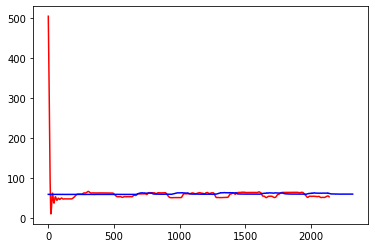

In [17]:
plt.plot(TASK_DFS_VIDEO_100HZ_LIST[0]['Horiz_Lip_Motion'],'r')
plt.plot(TASK_DFS_WAVE_100HZ_LIST[3]['Horiz_Lip_Motion'],'b')

In [18]:
print(len(TASK_DFS_VIDEO_100HZ_LIST))
print(len(TASK_DFS_WAVE_100HZ_LIST))

6
6


In [19]:
sn_pc = list()
sh_pc = list()

sn_rms_list = list()
sh_rms_list = list()

Final_DFS_LIST = list()

SPREAD_HOLD
Wave index:0
Video index:0
The phase shift is:174.24
The corrolation r and p-value between the signals are: r0.9667535760306141, p0.0

SPREAD_NORM
Wave index:1
Video index:1
The phase shift is:149.13
The corrolation r and p-value between the signals are: r0.9514445226770757, p0.0

SPREAD_HOLD
Wave index:2
Video index:2
The phase shift is:134.12
The corrolation r and p-value between the signals are: r0.816663086059577, p0.0

SPREAD_NORM
Wave index:3
Video index:3
The phase shift is:163.32
The corrolation r and p-value between the signals are: r0.866717336784808, p0.0

SPREAD_HOLD
Wave index:4
Video index:4
The phase shift is:164.75
The corrolation r and p-value between the signals are: r0.9193106651005393, p0.0

SPREAD_NORM
Wave index:5
Video index:5
The phase shift is:232.20000000000002
The corrolation r and p-value between the signals are: r0.8913303172107117, p0.0



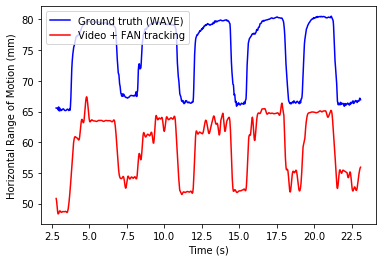

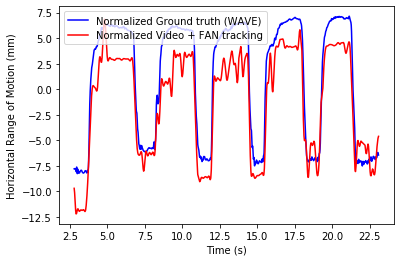

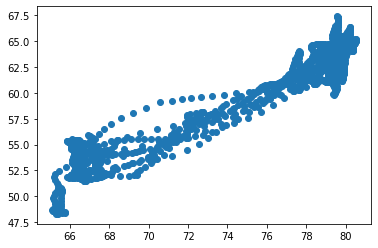

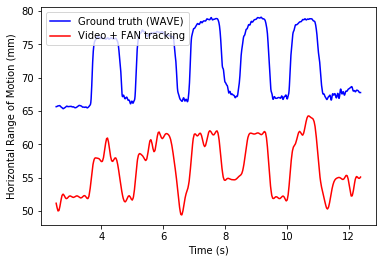

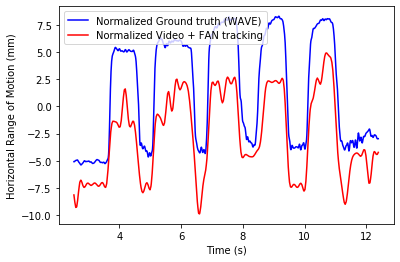

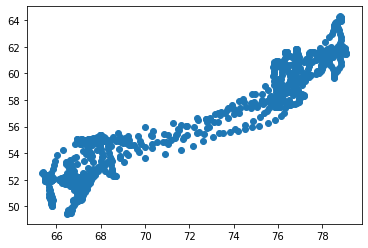

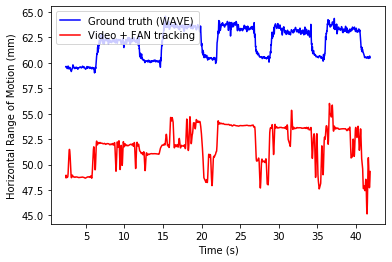

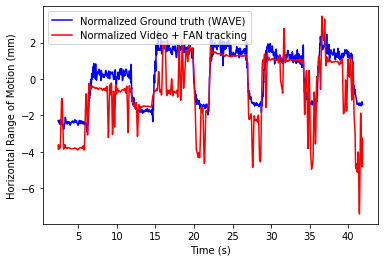

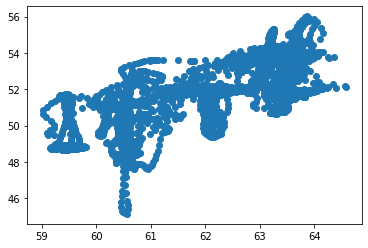

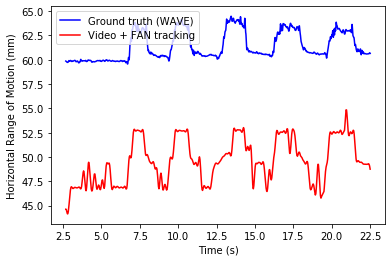

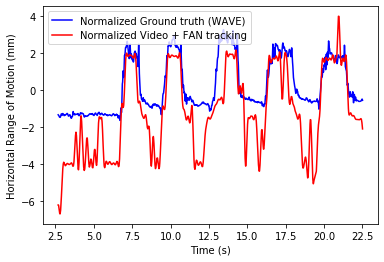

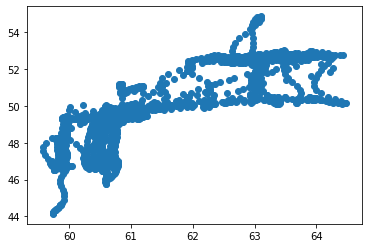

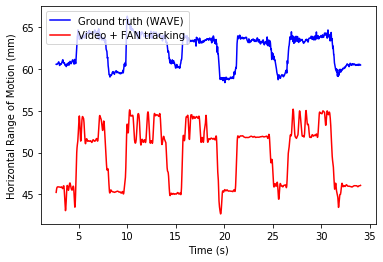

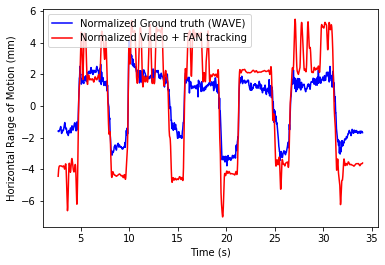

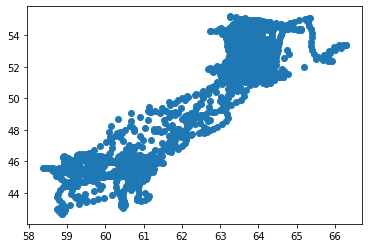

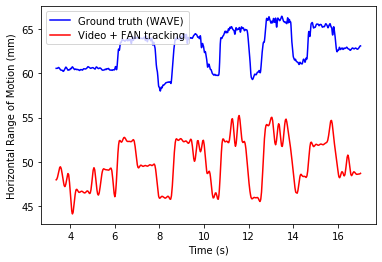

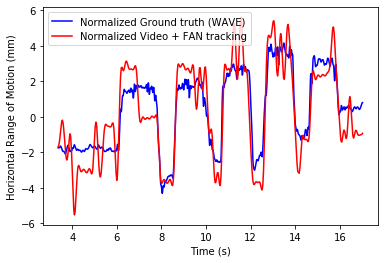

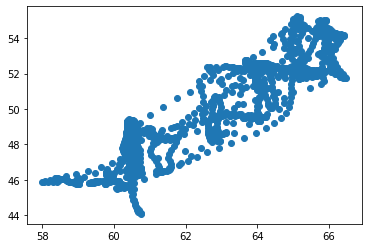

In [20]:
for i in range(len(TASK_DFS_WAVE_100HZ_LIST)):
    for j in range(len(TASK_DFS_VIDEO_100HZ_LIST)):
        if TASK_DFS_WAVE_100HZ_LIST[i]['PatientID'][1]== TASK_DFS_VIDEO_100HZ_LIST[j]['PatientID'][1]:
            if TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1]== TASK_DFS_VIDEO_100HZ_LIST[j]['FileName'][1]:
                print(TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1])
                print('Wave index:{}'.format(i))
                print('Video index:{}'.format(j))
                result = pd.DataFrame() 

                video_n = sig_norm(TASK_DFS_VIDEO_100HZ_LIST[j]['Horiz_Lip_Motion'])
                wave_n = sig_norm(TASK_DFS_WAVE_100HZ_LIST[i]['Horiz_Lip_Motion'])
                time = TASK_DFS_WAVE_100HZ_LIST[i]['Time'].values
                time_w = TASK_DFS_WAVE_100HZ_LIST[i]['Time'].values
                time_v = TASK_DFS_WAVE_100HZ_LIST[i]['Time'].values
                
                if len(video_n)<=len(wave_n):
                    upper_bound = len(video_n) 
                else: 
                    upper_bound = len(wave_n) 

               

                s = phase_align(wave_n, video_n, [5,upper_bound])
                print('The phase shift is:{}'.format(s))

                sp = math.ceil(s)


                video_shifted = sig_shift(TASK_DFS_VIDEO_100HZ_LIST[j]['Horiz_Lip_Motion'],sp)
                video_n_s = sig_shift( video_n,sp)
                video_speed_shifted = sig_shift(TASK_DFS_VIDEO_100HZ_LIST[j]['Speed'],sp)
                
                wave_shifted = TASK_DFS_WAVE_100HZ_LIST[i]['Horiz_Lip_Motion'].values
                wave_speed_shifted = TASK_DFS_WAVE_100HZ_LIST[i]['Speed'].values
                
                upper_bound_shifted = upper_bound + sp -1
                
                if len(wave_shifted)< upper_bound_shifted:
                    upper_bound_shifted = len(wave_shifted)
             
                name = TASK_DFS_WAVE_100HZ_LIST[i]['PatientID'][1] + '_' + TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1]
                
                range_l = sp+100
                range_u = upper_bound_shifted-10
                
                result['Time_WAVE'] = time_w[range_l:range_u]
                result['Time_VIDEO'] = time_v[range_l:range_u]
                result['HorizDisp_WAVE'] = wave_shifted[range_l:range_u]
                result['HorizDisp_VIDEO'] = video_shifted[range_l:range_u]
                
                result['Speed_WAVE'] = wave_speed_shifted[range_l:range_u]
                result['Speed_VIDEO'] = video_speed_shifted[range_l:range_u]
                
                result['FileName'] = TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1]
                result['PatientID'] = TASK_DFS_WAVE_100HZ_LIST[i]['PatientID'][1]
                cvs = 'final_paper_data/SPREAD_'+ name +'.csv'
                result.to_csv(cvs)
                Final_DFS_LIST.append(result)
                plt.figure()
                
                plt.plot(time[range_l:range_u], wave_shifted[range_l:range_u],'b', label='Ground truth (WAVE)')
                plt.plot(time[range_l:range_u],video_shifted[range_l:range_u],'r', label='Video + FAN tracking')
                plt.legend(loc="upper left")
                plt.xlabel('Time (s)')
                plt.ylabel('Horizontal Range of Motion (mm)')
                
                plt.savefig('{}'.format(name))
                
                
                plt.figure()
                
                plt.plot(time[range_l:range_u],wave_n[range_l:range_u],'b', label='Normalized Ground truth (WAVE)')
                plt.plot(time[range_l:range_u],video_n_s[range_l:range_u],'r', label='Normalized Video + FAN tracking')
                plt.legend(loc="upper left")
                plt.xlabel('Time (s)')
                plt.ylabel('Horizontal Range of Motion (mm)')
                plt.savefig('{}'.format(name+'Normalized'))


             
                plt.figure()
                plt.scatter(wave_shifted[range_l:range_u], video_shifted[range_l:range_u]) 
                
                
                r, p = stats.pearsonr(video_n_s[range_l:range_u], wave_n[range_l:range_u])
                print('The corrolation r and p-value between the signals are: r{}, p{}'.format(r,p))
                print()
                rms = np.sqrt(np.mean((wave_n[range_l:range_u]-video_n_s[range_l:range_u])**2))
                
                if TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1] == "SPREAD_HOLD":
                    sh_pc.append(r)
                    sh_rms_list.append(rms)
                elif TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1] == "SPREAD_NORM":
                    sn_pc.append(r)
                    sn_rms_list.append(rms)
                
                #plt.figure()
                #plt.plot(TASK_DFS_WAVE_100HZ_LIST[i]['Horiz_Lip_Motion'],'b')
                #plt.plot(TASK_DFS_VIDEO_100HZ_LIST[j]['Horiz_Lip_Motion'],'r')
               
                

                #plt.figure()
                #plt.plot(TASK_DFS_WAVE_100HZ_LIST[i]['Horiz_Lip_Motion'],'b')
                #plt.plot(video_shifted,'r')
             

                #plt.figure()
                #plt.scatter(TASK_DFS_WAVE_100HZ_LIST[i]['Horiz_Lip_Motion'][sp:signal_bound], 
                #            video_shifted[sp:signal_bound])

    

# START HERE

In [208]:
# DO NOT RUN MORE THAN ONCE
parsed_df = pd.DataFrame(columns=['PatientID','FileName','REP','ROM_VIDEO','ROM_WAVE', 'SpdAvg_WAVE', 
                                  'SpdAvg_VIDEO','Disp_WAVE', 'Disp_VIDEO','Time_WAVE', 'Time_VIDEO',
                                  'Speed_WAVE', 'Speed_VIDEO'])


reps = ['R1', 'R2', 'R3', 'R4', 'R5']
len(Final_DFS_LIST)

6

In [254]:
reps = ['R1', 'R2', 'R3', 'R4', 'R5']
#reps = ['R1', 'R2', 'R3', 'R4']

In [309]:
def apnd_adj (d, v, t, i):
    d[i] = d[i].append(d[i+1])
    v[i] = v[i].append(v[i+1])
    t[i] = t[i].append(t[i+1])
    d.pop(i+1)
    v.pop(i+1)
    t.pop(i+1)
    return d, v, t

In [283]:
# df at hand 
DF = Final_DFS_LIST[5]

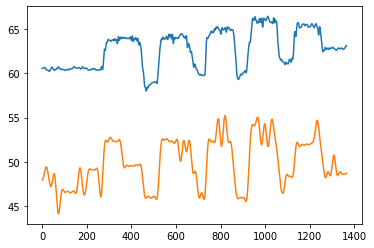

In [284]:
plt.plot(DF['HorizDisp_WAVE'])
plt.plot(DF['HorizDisp_VIDEO'])

In [299]:
peaks, _ = signal.find_peaks(-DF['HorizDisp_WAVE'], height= -63, distance= 50)

print(peaks)


[  32  105  174  251  467  666  725  880 1089 1260 1319]


In [300]:
reps_w = np.array_split(DF['HorizDisp_WAVE'], peaks)
reps_w_v = np.array_split(DF['Speed_WAVE'], peaks)
reps_w_t = np.array_split(DF['Time_WAVE'], peaks)

reps_v = np.array_split(DF['HorizDisp_VIDEO'], peaks)
reps_v_v = np.array_split(DF['Speed_VIDEO'], peaks)
reps_v_t = np.array_split(DF['Time_VIDEO'], peaks)

if 0:
    reps_v.pop(0)
    reps_v_v.pop(0)
    reps_v_t.pop(0)
    reps_v.pop(-1)
    reps_v_v.pop(-1)
    reps_v_t.pop(-1)
    reps_w.pop(0)
    reps_w_v.pop(0)
    reps_w_t.pop(0)
    reps_w.pop(-1)
    reps_w_v.pop(-1)
    reps_w_t.pop(-1)

print(len(reps_w))

12


In [306]:
if 0: 
    reps_w.pop(2)
    reps_w_v.pop(2)
    reps_w_t.pop(2)
    print(len(reps_w))
    
    reps_v.pop(2)
    reps_v_v.pop(2)
    reps_v_t.pop(2)
    print(len(reps_v), len(reps_w))
    

if 0: 
    reps_w.pop(-1)
    reps_w_v.pop(-1)
    reps_w_t.pop(-1)
    reps_v.pop(-1)
    reps_v_v.pop(-1)
    reps_v_t.pop(-1)
    print(len(reps_v), len(reps_w))
    
if 1: 
    reps_w.pop(0)
    reps_w_v.pop(0)
    reps_w_t.pop(0)
    reps_v.pop(0)
    reps_v_v.pop(0)
    reps_v_t.pop(0)
    print(len(reps_v),len(reps_w))

6 6


5 5


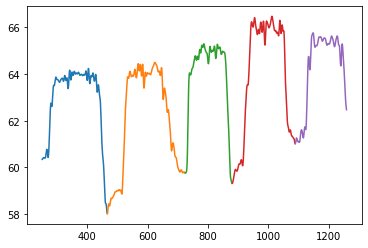

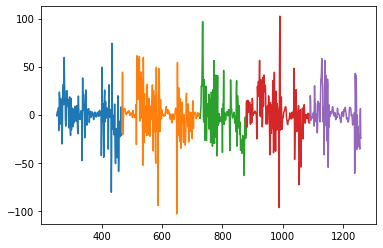

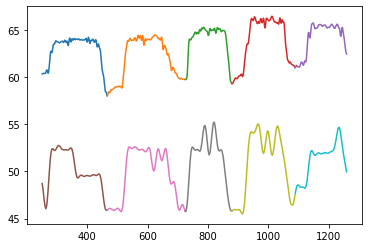

In [311]:
plt.figure()
for i in reps_w:
    plt.plot(i)

plt.figure()
for i in reps_w_v:
    plt.plot(i)
    
plt.figure()
for i in reps_w:
    plt.plot(i)
for i in reps_v:
    plt.plot(i)
print(len(reps_v),len(reps_w))

In [310]:
### CAUTION
if 1:
    reps_w, reps_w_v, reps_w_t = apnd_adj(reps_w, reps_w_v, reps_w_t, 1)
    reps_v, reps_v_v, reps_v_t = apnd_adj(reps_v, reps_v_v, reps_v_t, 1)

In [312]:
# ROM and AVG speed analysis 
rom_w = rom(reps_w)
rom_v = rom(reps_v)
ave_s_w = np.array([np.mean(abs(rep_v)) for rep_v in reps_w_v])
ave_s_v = np.array([np.mean(abs(rep_v)) for rep_v in reps_v_v])
print(rom_w)
print(rom_v)
print(ave_s_w)
print(ave_s_v)

[6.19043561 6.48967704 5.95087804 7.16179359 4.75856529]
[6.8967915  6.86853393 9.48584144 9.5413327  7.06671377]
[11.95464245 11.75727236 16.31288079 13.69048278 11.58708051]
[ 7.7397464   8.32994543 15.13523021 16.28826017  7.19758975]


In [313]:
current_df = pd.DataFrame()

current_df['REP'] = reps
current_df['PatientID'] =  DF['PatientID'][1]
current_df['FileName'] = DF['FileName'][1]  
current_df['ROM_WAVE'] = rom_w
current_df['ROM_VIDEO'] = rom_v
current_df['SpdAvg_WAVE'] = ave_s_w
current_df['SpdAvg_VIDEO'] = ave_s_v
current_df['Disp_WAVE'] = reps_w  
current_df['Time_WAVE'] = reps_w_t  
current_df['Time_VIDEO'] = reps_v_t
current_df['Disp_VIDEO'] = reps_v
current_df['Speed_WAVE'] = reps_w_v 
current_df['Speed_VIDEO'] = reps_v_v

current_df.head()

,REP,PatientID,FileName,ROM_WAVE,ROM_VIDEO,SpdAvg_WAVE,SpdAvg_VIDEO,Disp_WAVE,Time_WAVE,Time_VIDEO,Disp_VIDEO,Speed_WAVE,Speed_VIDEO
0,R1,RM,SPREAD_NORM,6.190436,6.896791,11.954642,7.739746,251 60.344455 252 60.352335 253 60.37...,251 5.876650 252 5.886653 253 5.89665...,251 5.876650 252 5.886653 253 5.89665...,251 48.713397 252 48.510261 253 48.30...,251 -0.461892 252 -1.477990 253 2.74...,251 -16.085324 252 -27.057672 253 -37.69...
1,R2,RM,SPREAD_NORM,6.489677,6.868534,11.757272,8.329945,467 58.008940 468 58.076581 469 58.21...,467 8.037371 468 8.047374 469 8.05...,467 8.037371 468 8.047374 469 8.05...,467 45.899650 468 45.933671 469 45.96...,467 -18.618416 468 16.732428 469 44.10...,467 -1.080167 468 -0.917047 469 -0.75392...
2,R3,RM,SPREAD_NORM,5.950878,9.485841,16.312881,15.135230,725 59.758245 726 59.761576 727 59.77...,725 10.618233 726 10.628236 727 10.63...,725 10.618233 726 10.628236 727 10.63...,725 45.779303 726 45.760298 727 45.74...,725 -2.986319 726 -4.027192 727 -0.02...,725 -0.069198 726 -0.127846 727 -0.18649...
3,R4,RM,SPREAD_NORM,7.161794,9.541333,13.690483,16.288260,880 59.314610 881 59.317376 882 59...,880 12.168750 881 12.178753 882 12...,880 12.168750 881 12.178753 882 12...,880 45.811654 881 45.824333 882 45...,880 14.163781 881 -4.662498 882 -12...,880 -0.584750 881 -0.930718 882 -0...
4,R5,RM,SPREAD_NORM,4.758565,7.066714,11.587081,7.197590,1089 61.008386 1090 61.032013 1091 61...,1089 14.259448 1090 14.269451 1091 14...,1089 14.259448 1090 14.269451 1091 14...,1089 47.608902 1090 47.804422 1091 47...,1089 -8.739626 1090 -3.898479 1091 19...,1089 24.483601 1090 12.578880 1091 0...


In [314]:
print(len(reps_w_t ))
print(len(reps_v_t ))

5
5


In [315]:
parsed_df = parsed_df.append(current_df,ignore_index=True)

print(len(parsed_df))

29


In [316]:
# MAKE SURE TO CHANGE THIS!!!!!!!!!

cvs = 'SPREAD_PARSED_ANALYSIS_2.csv'
parsed_df.to_csv(cvs)

# DONE!

In [317]:
for i in range(len(parsed_df)):
    rep_df = pd.DataFrame()
    
    rep_df['Disp_VIDEO'] = parsed_df['Disp_VIDEO'][i]
    rep_df['Speed_VIDEO'] = parsed_df['Speed_VIDEO'][i]
    rep_df['Time_VIDEO'] = parsed_df['Time_VIDEO'][i]
    
    
    rep_df['PatientID'] =  parsed_df['PatientID'][i]
    rep_df['FileName'] = parsed_df['FileName'][i]  

    rep_df['ROM_VIDEO'] = parsed_df['ROM_VIDEO'] [i]

    rep_df['SpdAvg_VIDEO'] = parsed_df ['ROM_VIDEO'][i]
    name = parsed_df['PatientID'][i] + '_' + parsed_df['FileName'][i] + '_VIDEO_' +parsed_df['REP'][i] 

    cvs = 'Parsed_Data2/SPREAD_'+ name +'.csv'
    current_df.to_csv(cvs)

In [319]:
deniz = parsed_df.loc[lambda DF: parsed_df['PatientID'] == 'DJ']
mk = parsed_df.loc[lambda DF: parsed_df['PatientID'] == 'MK']
rm = parsed_df.loc[lambda DF: parsed_df['PatientID'] == 'RM']